# Setup Enviornment

In [1]:
from monai.utils import first, set_determinism, ensure_tuple
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    RandAffined,
    RandRotate90d,
    RandShiftIntensityd,
    RandFlipd,
    RandGaussianNoised,
    RandAdjustContrastd,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    AddChanneld,
    RandGaussianSharpend,
    RandGaussianSmoothd,
    RandHistogramShiftd,
    OneOf,
    Rand3DElasticd,
    RandGridDistortiond,
    RandSpatialCropSamplesd,
    FillHoles,
    LabelFilter,
    LabelToContour
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.losses import DiceLoss, DiceCELoss, DiceFocalLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch, ImageReader
from monai.data.image_reader import WSIReader
from monai.config import print_config, KeysCollection, PathLike
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from pathlib import Path
import re
from skimage import io
from typing import Optional, Union, Sequence, Callable, Dict, List
from monai.data.utils import is_supported_format
from monai. data.image_reader import _copy_compatible_dict, _stack_images
from nibabel.nifti1 import Nifti1Image
from PIL import Image
import numpy as np
#import torch as torch
from tqdm import tqdm
#from torchio import RandomAffine
import warnings
warnings.filterwarnings('ignore')

/lustre06/project/6023374/rozakmat/monai/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
print_config()

MONAI version: 0.8.0
Numpy version: 1.21.2
Pytorch version: 1.10.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: 0.4.7
Nibabel version: 3.2.1
scikit-image version: 0.18.2
Pillow version: 7.0.0.post3
Tensorboard version: 2.7.0
gdown version: 4.2.0
TorchVision version: 0.11.1
tqdm version: 4.62.3
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.3.0
einops version: 0.3.2
transformers version: 4.15.0
mlflow version: 1.22.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
class TIFFReader(ImageReader):
    
    def __init__(self, npz_keys: Optional[KeysCollection] = None, channel_dim: Optional[int] = None, **kwargs):
        super().__init__()
        if npz_keys is not None:
            npz_keys = ensure_tuple(npz_keys)
        self.npz_keys = npz_keys
        self.channel_dim = channel_dim
        self.kwargs = kwargs
    
    def verify_suffix(self, filename: Union[Sequence[PathLike], PathLike]) -> bool:
        """
        Verify whether the specified file or files format is supported by Numpy reader.

        Args:
            filename: file name or a list of file names to read.
                if a list of files, verify all the suffixes.
        """
        suffixes: Sequence[str] = ["tif", "tiff"]
        return is_supported_format(filename, suffixes)

    def read(self, data: Union[Sequence[PathLike], PathLike], **kwargs):
        """
        Read image data from specified file or files, it can read a list of `no-channel` data files
        and stack them together as multi-channels data in `get_data()`.
        Note that the returned object is Numpy array or list of Numpy arrays.

        Args:
            data: file name or a list of file names to read.
            kwargs: additional args for `numpy.load` API except `allow_pickle`, will override `self.kwargs` for existing keys.
                More details about available args:
                https://numpy.org/doc/stable/reference/generated/numpy.load.html

        """
        img_: List[Nifti1Image] = []

        filenames: Sequence[PathLike] = ensure_tuple(data)
        kwargs_ = self.kwargs.copy()
        kwargs_.update(kwargs)
        for name in filenames:
            img = io.imread(name, **kwargs_)
            img = img.astype('float32')
            if len(img.shape)==4:
                img = np.swapaxes(img,0,1)
                img = np.swapaxes(img,1,3)
            img_.append(img)
        return img_ if len(img_) > 1 else img_[0]
    
    def get_data(self, img):
        """
        Extract data array and meta data from loaded image and return them.
        This function returns two objects, first is numpy array of image data, second is dict of meta data.
        It constructs `affine`, `original_affine`, and `spatial_shape` and stores them in meta dict.
        When loading a list of files, they are stacked together at a new dimension as the first dimension,
        and the meta data of the first image is used to represent the output meta data.

        Args:
            img: a Numpy array loaded from a file or a list of Numpy arrays.

        """
        img_array: List[np.ndarray] = []
        compatible_meta: Dict = {}
        if isinstance(img, np.ndarray):
            img = (img,)

        for i in ensure_tuple(img):
            header = {"affine":np.eye(5),
                     "labels": {"0": "background",
                                "1": "vessels",
                                "2": "neurons",}
                     }
            if isinstance(i, np.ndarray):
                # if `channel_dim` is None, can not detect the channel dim, use all the dims as spatial_shape
                spatial_shape = np.asarray(i.shape)
                if isinstance(self.channel_dim, int):
                    spatial_shape = np.delete(spatial_shape, self.channel_dim)
                header["spatial_shape"] = spatial_shape
            img_array.append(i)
            header["original_channel_dim"] = self.channel_dim if isinstance(self.channel_dim, int) else "no_channel"
            _copy_compatible_dict(header, compatible_meta)

        return _stack_images(img_array, compatible_meta), compatible_meta

# Hyperparameters

In [4]:
params = {}
params['crop_size'] = (160,160,160)
params['N_crops'] = 12
params["norm"] = Norm.INSTANCE
params["dropout"] = 0.1
params['optimizer'] = torch.optim.Adam
params["batch_size"] = 3
params['learning_rate'] = 5e-3
params["max_epochs"] = 10
params['num_res_units'] = 3
params['loss_function'] = DiceFocalLoss(to_onehot_y=True, softmax=True, focal_weight=[0.9,0.1], squared_pred=True, jaccard=True, include_background=False)
params['intensity_transform_probability'] = 0.4
params['gaussian_transform_probability'] = 0.4
params['rotation_flip_transforms_probability'] = 0.5
params['deformation_transforms_prob'] = 0.4
params['Rand3DElasticd_sigma_range'] = (0.5,2)
params['Rand3DElasticd_magnitude_range'] = (0.5,2)
params['RandGridDistortiond_num_cells'] = 8
params['RandGridDistortiond_distort_limit'] = (-0.1,0.1)
params['RandShiftIntensityd_offsets'] = 0.3
params['RandAdjustContrastd_gamma'] = (0.5,4.5)
params['RandHistogramShiftd_num_control_points'] = 4
params['RandGaussianNoised_mean'] = 0
params['RandGaussianNoised_std'] = 0.1

# setup directory to save enviornment

In [5]:
directory = os.environ.get("MONAI_TBI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp_zwxmkdr


# get train and validate data

In [6]:
#make list of data dictionaries
train_images_path = Path('../TBI/GT_filtered+raw/') #raw path images
train_images_paths = list(train_images_path.glob('*.tif'))#get images
train_images = sorted([x.as_posix() for x in train_images_paths])#sort
train_labels_path = Path('../TBI/GT_filtered+raw/')#labels path
train_labels = list(train_labels_path.glob('*sub1.tiff'))#get label images
train_labels = sorted([x.as_posix() for x in train_labels])#sort
#combine images and labels into monai dictionary format
data_dicts = [
    {"image":image_name, "label":label_name}
    for image_name, label_name in zip(train_images,train_labels)
]
#print(data_dicts)

In [7]:
mouse_ids_path = Path('../TBI/raw')#each mouse has its own folder with raw data in it
mouse_ids = list(mouse_ids_path.glob('*'))#grab molder names/mouse ids
images = sorted([y.name for y in train_images_paths])#sort
#get mouse id corresponding to each image i have labels for
mouse_ids_with_raw_tiff = []
for i in mouse_ids:
    for j in images:
        if len(list(i.glob(j))) !=0:
            mouse_ids_with_raw_tiff.append(list(i.glob(j)))
#flatten the list and sort
mouse_ids_with_raw_tiff_flat = [item for sublist in mouse_ids_with_raw_tiff for item in sublist]
mouse_ids_with_raw_tiff_flat = sorted(mouse_ids_with_raw_tiff_flat)
#print(mouse_ids)

In [8]:
#shuffle mouse ids for a 15/4/6 split train/val/test by mouse id
mouse_ids_present = [i.parent.name for i in mouse_ids_with_raw_tiff_flat]
mouse_ids_present = sorted(list(np.unique(mouse_ids_present)))
np.random.seed(643)
np.random.shuffle(mouse_ids_present)
mouse_ids_present
train = mouse_ids_present[:15]
val = mouse_ids_present[15:-6]
test = mouse_ids_present[-6:]
#print(test)
#code below this finds a seed to have previously descrive mice as validation in test set
#train
#seed = 0
#end = mouse_ids_present[-6:]
#while ('vbm03 Feb 26 2020' not in end) or ('vbm05 Feb 28 2020' not in end) or ('vbm07 Mar 24 2020' not in end):
#    np.random.seed(seed)
#    mouse_ids_present = sorted(mouse_ids_present)
#    np.random.shuffle(mouse_ids_present)
#    end = mouse_ids_present[-6:]
#    print(seed)
#    seed+=1

In [9]:
train_files = []
val_files = []
test_files = []
for i in train:
    for j in mouse_ids_with_raw_tiff_flat:
        if i in j.as_posix():
            for k in data_dicts:
                if j.name in k["image"]:
                    train_files.append(k)
for i in val:
    for j in mouse_ids_with_raw_tiff_flat:
        if i in j.as_posix():
            for k in data_dicts:
                if j.name in k["image"]:
                    val_files.append(k)
for i in test:
    for j in mouse_ids_with_raw_tiff_flat:
        if i in j.as_posix():
            for k in data_dicts:
                if j.name in k["image"]:
                    test_files.append(k)

# Set deterministic training for reproducability

In [10]:
set_determinism(seed=12)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `AddChanneld` as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.
1. `EnsureTyped` converts the numpy array to PyTorch Tensor for further steps.

In [11]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], reader = TIFFReader(channel_dim = 0)),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.01, 1.01, 0.3787), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=1024,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        AsDiscreted(keys="label",
                   rounding='torchrounding',
                   to_onehot=True),
        #RandCropByPosNegLabeld(
        #    keys = ["image", "label"],
        #    label_key = "label",
        #    spatial_size = params['crop_size'],
        #    pos = 10,
        #    neg = 1,
        #    num_samples = params['N_crops'],
        #    image_key = "image",
        #    image_threshold = 0,
        #),
        RandSpatialCropSamplesd(
            keys=['image','label'],
            num_samples = params['N_crops'],
            roi_size = params['crop_size'],
            random_size = False
        ),
        #Deformation_transforms
        OneOf(transforms=[Rand3DElasticd(keys = ["image","label"],
                                        sigma_range = params['Rand3DElasticd_sigma_range'],
                                        magnitude_range = params['Rand3DElasticd_magnitude_range'],
                                        prob = params["deformation_transforms_prob"],
                                        mode = ["bilinear","nearest"]),
                          RandGridDistortiond(keys = ["image","label"],
                                             num_cells = params['RandGridDistortiond_num_cells'],
                                             prob = params["deformation_transforms_prob"],
                                             distort_limit = params['RandGridDistortiond_distort_limit'],
                                             mode = ["bilinear","nearest"]
                                             )
                         ]
             ),
        #Intensity_Transforms
        OneOf(transforms = [RandShiftIntensityd(keys = ["image"],
                                                offsets = params['RandShiftIntensityd_offsets'],
                                                prob = params["intensity_transform_probability"]),
                            RandAdjustContrastd(keys = ["image"],
                                                prob = params["intensity_transform_probability"],
                                                gamma = params['RandAdjustContrastd_gamma']),
                            RandHistogramShiftd(keys = ["image"],
                                                prob = params["intensity_transform_probability"],
                                                num_control_points = params['RandHistogramShiftd_num_control_points'])
                           ]
             ),
        #Gaussian_Transforms
        OneOf(transforms = [RandGaussianSharpend(keys = ["image"],
                                                 prob = params["gaussian_transform_probability"]),
                            RandGaussianSmoothd(keys = ["image"],
                                                prob = params["gaussian_transform_probability"]),
                            RandGaussianNoised(keys = ["image"],
                                               prob = params["gaussian_transform_probability"],
                                               mean = params['RandGaussianNoised_mean'],
                                               std = params['RandGaussianNoised_std'])
                           ]
             ),
        #rottion+flip_transforms
        RandRotate90d(
            keys = ["image", "label"],
            prob = params['rotation_flip_transforms_probability'],
            max_k = 3,
        ),
        RandFlipd(
            keys = ["image", "label"],
            spatial_axis = [0],
            prob = params['rotation_flip_transforms_probability'],
        ),
        RandFlipd(
            keys = ["image", "label"],
            spatial_axis = [1],
            prob = params['rotation_flip_transforms_probability'],
        ),
        RandFlipd(
            keys = ["image", "label"],
            spatial_axis = [2],
            prob = params['rotation_flip_transforms_probability'],
        ),
        
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"],reader = TIFFReader(channel_dim = 0)),
        #AddChanneld(keys=["label"]),
        #AddChanneld(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.01, 1.01, 0.3787), mode=("bilinear", "nearest")),
        #Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=1024,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
        AsDiscreted(keys="label",
                   rounding='torchrounding',
                   to_onehot=True),
        EnsureTyped(keys=["image", "label"]),
    ]
)

val_transforms_deform = Compose(
    [
        LoadImaged(keys=["image", "label"],reader = TIFFReader(channel_dim = 0)),
        #AddChanneld(keys=["label"]),
        #AddChanneld(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.01, 1.01, 0.3787), mode=("bilinear", "nearest")),
        #Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=1024,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
        AsDiscreted(keys="label",
                   rounding='torchrounding',
                   to_onehot=True),
        Rand3DElasticd(keys = ["image","label"],
                              sigma_range = (1,2),
                              magnitude_range = (3,10),
                              prob = 1,
                              mode = ["bilinear","nearest"]
                      ),
        #OneOf(transforms=[Rand3DElasticd(keys = ["image","label"],
        #                                sigma_range = (1,2),
        #                                magnitude_range = (1.1,2),
        #                                prob = 1,
        #                                mode = ["bilinear","nearest"]),
        #                  RandGridDistortiond(keys = ["image","label"],
        #                                     num_cells = 4,
        #                                     prob = 1,
        #                                     distort_limit = (-1,1),
        #                                     mode = ["bilinear","nearest"]
        #                                     )
        #                 ]
        #     ),
        EnsureTyped(keys=["image", "label"]),
    ]
)

# Check transforms in DataLoader

image shape: torch.Size([2, 507, 507, 252]), label shape: torch.Size([1, 507, 507, 252])


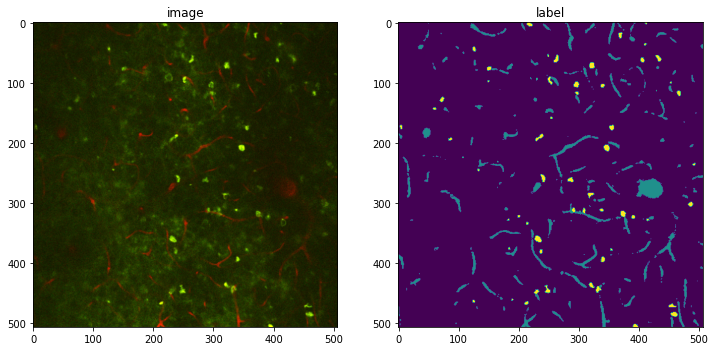

image shape: torch.Size([2, 507, 507, 252]), label shape: torch.Size([1, 507, 507, 252])


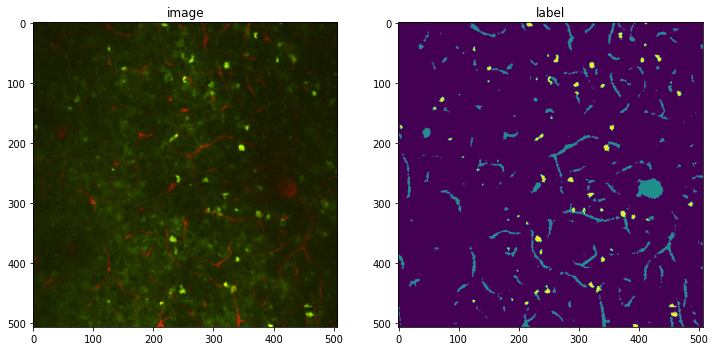

In [12]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0], check_data["label"][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [ :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
img2 = torch.swapaxes(image[:,:, :, 80],0,2)
img2 = img2.cpu().detach().numpy()
img2 = np.append(img2,np.zeros((507,507,1)), axis=2)/np.max(img2)
plt.imshow(img2, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
img3 = torch.swapaxes(label[:,:, :, 80],0,2)
img3 = img3.cpu().detach().numpy()
#img3 = np.append(img3,np.zeros((507,507,1)), axis=2)
plt.imshow(img3)
plt.show()

check_ds = Dataset(data=val_files, transform=val_transforms_deform)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image2, label2 = (check_data["image"][0], check_data["label"][0])
print(f"image shape: {image2.shape}, label shape: {label2.shape}")
# plot the slice [ :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
img2 = torch.swapaxes(image2[:,:, :, 80],0,2)
img2 = img2.cpu().detach().numpy()
img2 = np.append(img2,np.zeros((507,507,1)), axis=2)/np.max(img2)
plt.imshow(img2, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
img3 = torch.swapaxes(label2[:,:, :, 80],0,2)
img3 = img3.cpu().detach().numpy()
#img3 = np.append(img3,np.zeros((507,507,1)), axis=2)
plt.imshow(img3)
plt.show()

post_label = Compose([EnsureType(), AsDiscrete(to_onehot=3)])

label = post_label(label)
label2 = post_label(label2)

In [13]:
#label_filter = Compose([EnsureType(), LabelFilter(applied_labels=(1))])
#
#dice_metric = DiceMetric(include_background=False, reduction="mean")
##label = label_filter(label)
##label2 = label_filter(label2)
#contour = LabelToContour()(label_filter(label))
#print(contour.shape)
#contour2 = LabelToContour()(label_filter(label2))
#dice_metric(y_pred=contour, y=contour2)
#metric = dice_metric.aggregate().item()
#dice_metric.reset()
#print(metric)
#print(label2.ne(label).long())
#label.shape

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [14]:
!nvidia-smi

Tue Jan 25 17:04:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:01:00.0 Off |                    0 |
| N/A   30C    P0    50W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  Off  | 00000000:41:00.0 Off |                    0 |
| N/A   

In [15]:
#torch.cuda.empty_cache()

In [16]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=params["batch_size"], shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

val_ds_deform = CacheDataset(
    data=val_files, transform=val_transforms_deform, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader_deform = DataLoader(val_ds_deform, batch_size=1, num_workers=4)

Loading dataset: 100%|████████████████████████████| 6/6 [00:12<00:00,  2.04s/it]


# Create Model, Loss, Optimizer

In [17]:
params['optimizer'] = torch.optim.Adam
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
#device = torch.device("cuda:0")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=params['num_res_units'],
    norm=params["norm"],
    dropout=params["dropout"]
)#.to(device)
model = torch.nn.DataParallel(model)
model.to(device)
loss_function = params['loss_function']
optimizer = params['optimizer'](params = model.parameters(), 
                                lr = params['learning_rate'])
dice_metric = DiceMetric(include_background=False, 
                         reduction="mean")
hausdorf_distance_metric = HausdorffDistanceMetric(include_background=False,
                                                   distance_metric='euclidean')
dice_metric_deform = DiceMetric(include_background=False,
                                reduction="mean")
dice_metric_deform_boundary_difference = DiceMetric(include_background=False,
                                                    reduction="mean")
dice_metric_predicted_deform_boundary_difference = DiceMetric(include_background=False,
                                                              reduction="mean")
dice_metric_boundary_difference_detection = DiceMetric(include_background=False,
                                                       reduction="mean")
label_filter = Compose([EnsureType(),
                        LabelFilter(applied_labels=(1))])

# Execute a typical PyTorch training process

In [ ]:
max_epochs = params["max_epochs"]
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
hausdorf_distance_values = []
metric_values_deform = []
metric_values_deform_boundary_difference = []
metric_values_predicted_deform_boundary_difference = []
metric_values_boundary_difference_detection = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True,to_onehot=3)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=3)])

for epoch in tqdm(range(max_epochs)):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data, val_data_deform in zip(val_loader,val_loader_deform):
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_inputs_deform, val_labels_deform = (
                    val_data_deform["image"].to(device),
                    val_data_deform["label"].to(device),
                )
                roi_size = (128, 128, 128)
                sw_batch_size = 1
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs_deform = sliding_window_inference(
                    val_inputs_deform, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_outputs_deform = [post_pred(i) for i in decollate_batch(val_outputs_deform)]
                #fill holes in prediction
                filled  = [FillHoles(applied_labels=[1],connectivity=2)(i) for i in val_outputs]
                filled_deform  = [FillHoles(applied_labels=[1],connectivity=2)(i) for i in val_outputs_deform]
                #generated boundaries from predictions
                filled_vessels_boundary = [LabelToContour()(label_filter(i)) for i in filled]
                filled_vessels_boundary_deform = [LabelToContour()(label_filter(i)) for i in filled_deform]
                #get labelled data
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                val_labels_deform = [post_label(i) for i in decollate_batch(val_labels_deform)]
                #get validation boundaries
                val_labels_boundary = [LabelToContour()(i) for i in val_labels]
                val_labels_boundary_deform = [LabelToContour()(i) for i in val_labels_deform]
                # compute metric for current iteration
                #dice metric for ground truth and prediction
                dice_metric(y_pred=filled,
                            y=val_labels)
                hausdorf_distance_metric(y_pred=filled, 
                                         y=val_labels)
                #dice metric for deformed ground truth, and prediction
                dice_metric_deform(y_pred=filled_deform,
                                   y=val_labels_deform)
                #dice metric for boundary of ground truth and deformed ground truth
                dice_metric_deform_boundary_difference(y_pred=val_labels_boundary,
                                                       y=val_labels_boundary_deform)
                #dice metric for doundary between prediction on raw i=mage and deformed image
                dice_metric_predicted_deform_boundary_difference(y_pred=filled_vessels_boundary,
                                                                 y=filled_vessels_boundary_deform)
                #dice metric for boundary detection
                dice_metric_boundary_difference_detection(y_pred=val_labels_boundary[0].ne(val_labels_boundary_deform[0]).long(),
                                                          y=filled_vessels_boundary[0].ne(filled_vessels_boundary_deform[0]).long())

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            hausdorf_distance = hausdorf_distance_metric.aggregate().item()
            metric_deform = dice_metric_deform.aggregate().item()
            metric_deform_boundary_difference = dice_metric_deform_boundary_difference.aggregate().item()
            metric_predicted_deform_boundary_difference = dice_metric_predicted_deform_boundary_difference.aggregate().item()
            metric_boundary_difference_detection = dice_metric_boundary_difference_detection.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()
            hausdorf_distance_metric.reset()
            dice_metric_deform.reset()
            dice_metric_deform_boundary_difference.reset()
            dice_metric_predicted_deform_boundary_difference.reset()
            dice_metric_boundary_difference_detection.reset()

            metric_values.append(
                metric
            )
            hausdorf_distance_values.append(
                hausdorf_distance
            )
            metric_values_deform.append(
                metric_deform
            )
            metric_values_deform_boundary_difference.append(
                metric_deform_boundary_difference
            )
            metric_values_predicted_deform_boundary_difference.append(
                metric_predicted_deform_boundary_difference
            )
            metric_values_boundary_difference_detection.append(
                metric_boundary_difference_detection
            )
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\ncurrent mean hausdorf distance: {hausdorf_distance:.4f}"
                f"\ncurrent mean dice of deformed images: {metric_deform:.4f}"
                f"\ncurrent mean dice of boundary of ground truth, and  boundary of deformed ground truth: {metric_deform_boundary_difference:.5f}"
                f"\ncurrent mean dice of preficted boundary, and predicted deformed boundary: {metric_predicted_deform_boundary_difference:.5f}"
                f"\ncurrent mean dice of the boundary difference due to deformation: {metric_boundary_difference_detection:.5f}"
                f"\nratio of dice of boundary deformation to ground truth on prediction and ground truth:{metric_predicted_deform_boundary_difference/metric_deform_boundary_difference}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

  0%|                                                    | 0/10 [00:00<?, ?it/s]

----------
epoch 1/10
1/9, train_loss: 1.1704
2/9, train_loss: 1.0680
3/9, train_loss: 1.0230
4/9, train_loss: 1.0249
5/9, train_loss: 1.0135
6/9, train_loss: 1.0228
7/9, train_loss: 0.9723
8/9, train_loss: 0.9525


 10%|████▍                                       | 1/10 [01:00<09:01, 60.21s/it]

9/9, train_loss: 0.9294
epoch 1 average loss: 1.0197
----------
epoch 2/10
1/9, train_loss: 0.9332
2/9, train_loss: 0.9127
3/9, train_loss: 0.8850
4/9, train_loss: 0.9018
5/9, train_loss: 0.8488
6/9, train_loss: 0.7579
7/9, train_loss: 0.7852
8/9, train_loss: 0.7853
9/9, train_loss: 0.7011
epoch 2 average loss: 0.8346


 20%|████████▌                                  | 2/10 [06:38<29:50, 223.79s/it]

saved new best metric model
current epoch: 2 current mean dice: 0.5420
current mean hausdorf distance: 70.2850
current mean dice of deformed images: 0.5373
current mean dice of boundary of ground truth, and  boundary of deformed ground truth: 0.93311
current mean dice of preficted boundary, and predicted deformed boundary: 0.94254
current mean dice of the boundary difference due to deformation: 0.04178
ratio of dice of boundary deformation to ground truth on prediction and ground truth:1.0100993525225672
best mean dice: 0.5420 at epoch: 2
----------
epoch 3/10


In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}"
)

# Plot the loss and metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.savefig('ipynb_trial_Val_Loss+Dice.png')
plt.show()

# Check best model output with the input image and label

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

# Evaluation on original image spacings

In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode="bilinear"),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

val_org_ds = Dataset(
    data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    AsDiscreted(keys="label", to_onehot=2),
])

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)